<a href="https://colab.research.google.com/github/daphnecor/NeuroAnalysis/blob/main/NA2_SVMDecoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neuro Analysis 2: SVM decoding

```
Student: Daphne Cornelisse 1066862
```

In [1]:
# @title Commands to run matlab code in colab notebook [ignore]
# !pip install oct2py
# !apt-get install octave

# %reload_ext oct2py.ipython

# Introduction

- Neural activity may be correlated to some behavioural features (e.g. place cells correlate with the position of the animal).
- Here, we would like to decode this information - whether the neural activity correlates with some behavioural feature.
- To do this, we use a SVM classifier.



In [2]:
'''
Dependencies
'''
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import seaborn as sns

# Plotting aesthetics
sns.set_style('white')
cs = ['#EB3E1D', '#FBD490', '#C1B095', '#415667', '#1D3644', '#183D51']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=cs)
np.set_printoptions(suppress=True, precision=3)
sns.set_context('notebook', font_scale = 1.2, rc = {'lines.linewidth':2, })

# Reproducability
np.random.seed(0)

## 1 Simulating data

> First, we simulate our own spiking data for a group of neurons.

### 1.1 Creating the neuron firing rate profiles

The mean firing rate of each neuron will be modulated by a multiplicative factor during the stimuli presentation, drawn from a normal distribution with $\mu =$ 1 and $\sigma =$ 0.5.

In [3]:
n_cells = 20 # Number of neurons
n_stim_type = 2 # Number of stimuli

average_fr_rate = 5 # The peak firing rate, averaged across the population
cell_rate_baseline = np.random.exponential(scale=average_fr_rate, size=n_cells) # Sample from an exponential distribution

In [4]:
# During the stimuli the firing rate of the neurons will change.

# The mean firing rate of each neuron will be modulated when the stimulus is presented
# Here we draw the modulation factor from a random normal distribution with mu=1, sigma=0.5
modulation = np.random.normal(loc=1, scale=0.5, size=n_cells)

# Use opposite modulations for the different stimuli. 
# In other words, if stim 1 is modulated by 1.2, stim 2 is modulated by 0.8.
cell_rate_stim1 = cell_rate_baseline * modulation
cell_rate_stim2 = cell_rate_baseline * 2 - modulation

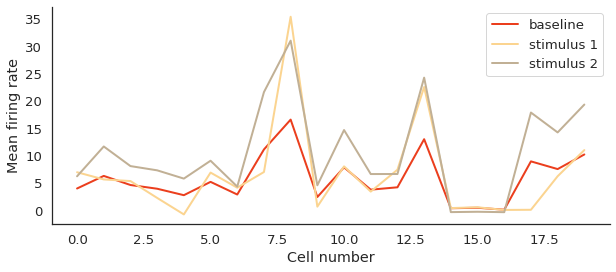

In [5]:
fig, axs = plt.subplots(1, 1, figsize=(10, 4))
axs.plot(cell_rate_baseline, label='baseline')
axs.plot(cell_rate_stim1, label='stimulus 1')
axs.plot(cell_rate_stim2, label='stimulus 2')
axs.set_xlabel('Cell number')
axs.set_ylabel('Mean firing rate')
axs.legend()
sns.despine()

In [6]:
# Construct 3D tensor to store data: (neurons, condition [BL/STIM], stimulus type [1/2])
cell_rate = np.zeros((n_cells, 2, n_stim_type))

cell_rate[:, 0, 0] = cell_rate_baseline
cell_rate[:, 0, 1] = cell_rate_baseline

cell_rate[:, 1, 0] = cell_rate_stim1
cell_rate[:, 1, 1] = cell_rate_stim2

# Remove negative firing rates
cell_rate[cell_rate < 0] = 0

In [7]:
cell_rate[:, :, 0].shape

(20, 2)

### 1.2 Display activity pre and post stimulus

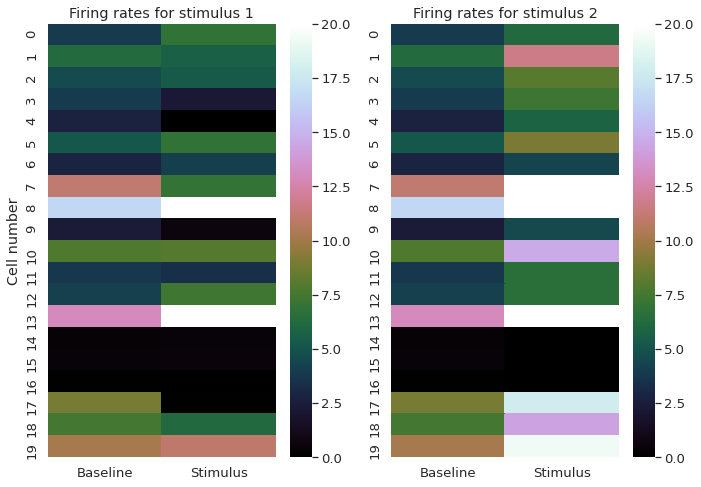

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 7))

axs[0].set_title('Firing rates for stimulus 1')
sns.heatmap(cell_rate[:, :, 0], cmap='cubehelix', xticklabels=['Baseline', 'Stimulus'], vmin=0, vmax=20, ax=axs[0])

axs[1].set_title('Firing rates for stimulus 2')
sns.heatmap(cell_rate[:, :, 1], cmap='cubehelix', xticklabels=['Baseline', 'Stimulus'], vmin=0, vmax=20, ax=axs[1])
axs[0].set_ylabel('Cell number')
plt.tight_layout()

### 1.3 Generate spiking data

In [9]:
srate = 10000 # Sampling rate of the simulated recording system
noise_rate = 1 
n_stim = 100 # Number of stimuli

stim_dur = 2 # Stimulus duration in seconds
stim_interval = 5 # Interval between stimuli in seconds

# Define stimulus onset
stim_times = np.arange(0, stim_interval * n_stim, stim_interval)

# First column is stimulus 1, second column is stimulus 2
stim_type = np.concatenate([np.zeros((int(n_stim/2))), np.ones((int(n_stim/2)))])

ttime = np.max(stim_times) + stim_interval
time = np.arange(0, ttime, 1/srate)

In [10]:
spike_times = []

for c in range(n_cells): # Iterate through cells

  # Simulate spikes with Poisson process with lambda as the firing rate of this cell
  spikes = np.random.poisson(lam = cell_rate[c, 0, 0] / srate, size=len(time))

  for itype in range(n_stim_type):

    idx = np.where(stim_type == itype)
    stim_onsets = stim_times[idx] 

    for stim_start in stim_onsets:
      
      ss_idx = np.where((time > stim_start) & (time <= stim_start + stim_dur))
      spikes[ss_idx] = np.random.poisson(lam = (cell_rate[c, 1, itype]) / srate, size=(len(ss_idx[0])))

  # Add a bit of Poisson noise
  spikes += np.random.poisson(lam = noise_rate/srate, size=(time.shape[0]))

  # Get indices where neurons spiked and store for this neuron
  spike_idx = np.where(spikes > 0)
  spike_times.append(time[spike_idx])

Now, we have the following variables:

- `spike_times`: a lis of size (`ncells`, `T`) indicating the timepoints at which each neuron spikes
- `stim_times`: the timepoints at which a stimuli is presented.
- `stim_type`: the stimulus type that is applied (1 or 2)

In [11]:
stim_type

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [12]:
stim_times

array([  0,   5,  10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,
        65,  70,  75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125,
       130, 135, 140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190,
       195, 200, 205, 210, 215, 220, 225, 230, 235, 240, 245, 250, 255,
       260, 265, 270, 275, 280, 285, 290, 295, 300, 305, 310, 315, 320,
       325, 330, 335, 340, 345, 350, 355, 360, 365, 370, 375, 380, 385,
       390, 395, 400, 405, 410, 415, 420, 425, 430, 435, 440, 445, 450,
       455, 460, 465, 470, 475, 480, 485, 490, 495])

## 2 Analyzing the simulated data

Let's analyze the data that we have just simulated.

### 2.1 Extract number of spikes per unit time

- Extract the number spikes per some unit of time for each cell, and organize this data into different trials. 
- We use bins of 100 ms with no overlap, going from 1 s before the start of each stimulus and to 3 s after it. 
- The resultant structure is a _N_ by _T_ by _B_ spike count matrix, where
  - _N_: number of neurons (20) 
  - _T_: number of trials (100) 
  - _B_: number of bins (40, in this case)

In [13]:
binwidth = 0.1 # seconds
bins = np.arange(-1, 3.1, binwidth) # construct bins
n_trials = len(stim_type) # number of experiments or trials

bins.shape

(41,)

In [14]:
spike_arr = np.zeros((n_cells, n_trials, len(bins)-1))

for c in range(n_cells): # Iterate over cells

  spikes_c = spike_times[c] # Select spike times of this cell
  #print(f'Spike times: {spikes_c}')

  for trial in range(1, n_trials): # For each trial

    #print(f'In trial {trial}, the stimulus is applied at time bin {stim_times[trial]}')
    #print(f'We count the spikes occured in the interval: [{stim_times[trial]-1} (pre-stimulus) - {stim_times[trial]+3}]')
    idx = np.where((spikes_c > stim_times[trial]-1) & (spikes_c <= stim_times[trial]+3))
    
    spikes_temp = spikes_c[idx] - stim_times[trial]

    # Return the count of spikes at each bin
    count, _ = np.histogram(spikes_temp, bins)

    # Store
    spike_arr[c, trial, :] = count

In [15]:
spike_arr.shape # neurons, trials, bins

(20, 100, 40)

### 2.2 Plot activity of a sample neuron

Let's see the activity of one neuron across the time bins for different trials. Find a neuron in which you can clearly see the simulus modulation.


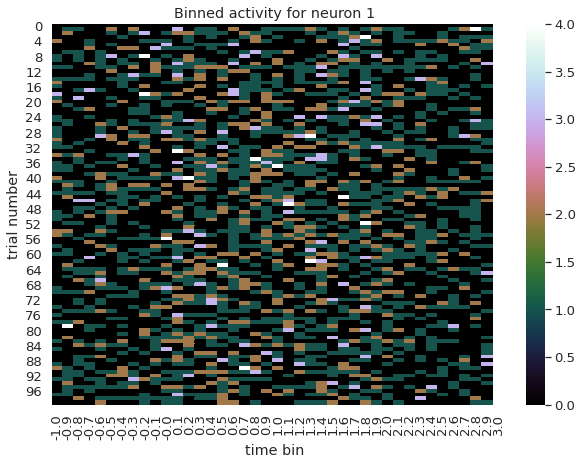

In [16]:
'''
Select a neuron
'''
neuron = 0

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
axs.set_title(f'Binned activity for neuron {neuron+1}')
hm = sns.heatmap(spike_arr[neuron, :, :], xticklabels=np.round(bins,1), cmap='cubehelix', ax=axs)
axs.set_xlabel('time bin')
axs.set_ylabel('trial number');

### 2.3 Create a SVM classifier


In [17]:
'''
Dependencies
'''
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn import svm

In [18]:
'''
Choose a bin
'''
bin = 0

In [19]:
k = 2 # Number of folds
X = spike_arr[:, :, bin].T # Select data
y = stim_type 

kf = KFold(n_splits=k, shuffle=True) # Split the data into k folds
kf.get_n_splits(X)

model = svm.SVC() # Initialize model

acc_score = []

for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(X_train, y_train)
    pred_values = model.predict(X_test)
     
    acc = accuracy_score(pred_values, y_test)
    acc_score.append(acc)
     
avg_acc_score = np.sum(acc_score)/k

print(f'Accuracy of each fold {acc_score}')
print(f'Mean accuracy {avg_acc_score}')

Accuracy of each fold [0.52, 0.46]
Mean accuracy 0.49



---

> **Exercise 1**: Calculate the mean performance for all the time bins and make a plot of the mean performance vs time from the stimulus.

---

Since we can't train the SVM on a 3D tensor, we select a specific bin and get a matrix of size `(n_cells, n_trials)`. By adding one additional for loop, we can look at the performance across time bins. The mean performance is significantly higher upon the presentation of the stimulus, to about 20 time bins after.

In [20]:
spike_arr.shape

(20, 100, 40)

In [21]:
k = 2 # Number of folds
y = stim_type 

mean_acc_bins = []

for bin in range(spike_arr.shape[2]):
  
  # Select data for time bin
  X = spike_arr[:, :, bin].T 
  kf = KFold(n_splits=k, shuffle=True) 
  kf.get_n_splits(X)
  model = svm.SVC() # Initialize model
  
  acc_score_fold = []

  for train_index, test_index in kf.split(X):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

      model.fit(X_train, y_train)
      pred_values = model.predict(X_test)
      
      acc = accuracy_score(pred_values, y_test)
      acc_score_fold.append(acc)
      
  mean_acc_bins.append(np.sum(acc_score_fold)/k)

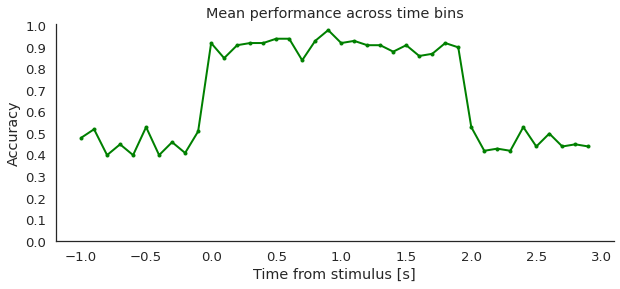

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
axs.set_title(f'Mean performance across time bins')
axs.set_ylabel('Accuracy')
axs.set_xlabel('Time from stimulus [s]')
axs.plot(bins[:-1], mean_acc_bins, 'g.-')
axs.set_yticks(np.arange(0, 1.1, 0.1))
sns.despine()


---

> **Exercise 2**: Explore different settings of the variable modulation (i.e., try to change the std of the distribution from which the its drawn). Compare the plot in Question 1 for each modulation value. What happens to the mean performance when you increase or decrease the std? 
Try to reason an explanation for the results you found. (Hint: try values like 0.1, 0.5 and 2).

---

Please find the mean performance plots for modulations with $\sigma = \{0.1, 0.5, 2.\}$ below. I notice that, as $\sigma$ increases, the mean performance stabilizes from timebins [0, 20]. This could be because increasing sigma will lead to a very high mean firing rate for stimulus 1. Since stimulus 2 is 2 - the modulation, the mean firing rate of stimulus 2 will decrease. In other words, stimulus 1 will dominate (the firing patterns become very distinct) and it is thus easier to distinguish (decode) between the two stimuli. 



**If $\sigma =0.2$**

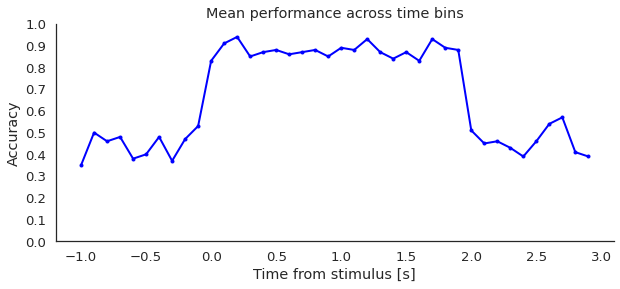


**If $\sigma =0.5$**

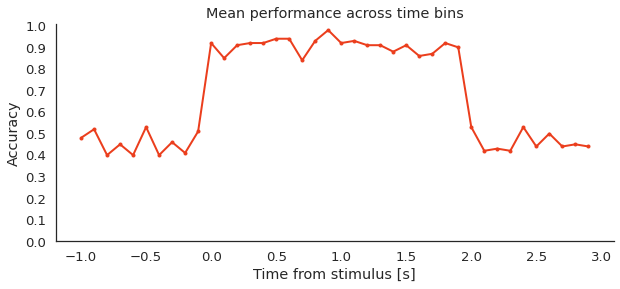

**If $\sigma =2$**

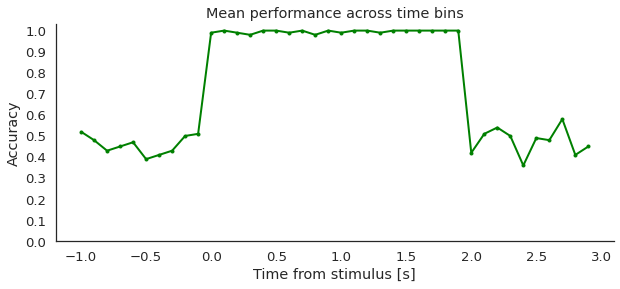

### 2.4 Assessing statistical significance with *surrogates*


`sklearn` as a build in 'shuffle' argument. I use this to shuffle the labels. 

In [23]:
def compute_surrogates(spike_arr, ibin, n_surr, k=2):
  ''' Compute surrogates for given time bin'''

  X = spike_arr[:, :, ibin].T # Select data
  y = stim_type # Select labels    
  mean_surr_acc = np.zeros(n_surr)

  for s in range(n_surr):

    kf = KFold(n_splits=k, shuffle=True) # Shuffle the data
    kf.get_n_splits(X)
    
    acc_score_fold = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        model.fit(X_train, y_train)
        pred_values = model.predict(X_test)
        
        acc = accuracy_score(pred_values, y_test)
        acc_score_fold.append(acc)
        
    mean_surr_acc[s] = (np.sum(acc_score_fold)/k)

  return mean_surr_acc

In [24]:
'''
Choose a bin and compute surrogates
'''

surrogate_distrib_ibin1 = compute_surrogates(spike_arr, ibin=0, n_surr=100, k=2)

surrogate_distrib_ibin15 = compute_surrogates(spike_arr, ibin=14, n_surr=100, k=2)

surrogate_distrib_ibin30 = compute_surrogates(spike_arr, ibin=29, n_surr=100, k=2)

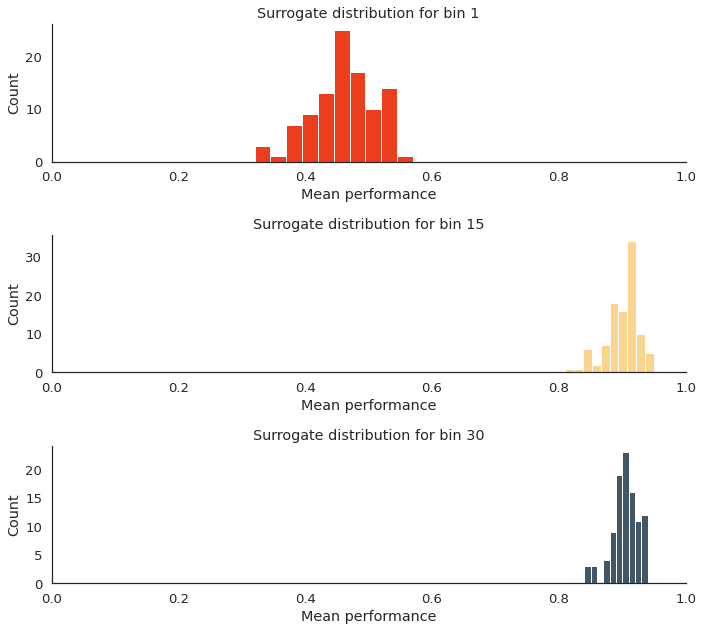

In [25]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 9))
axs[0].set_title(f'Surrogate distribution for bin 1')
axs[0].set_xlabel('Mean performance')
axs[0].set_ylabel('Count')
axs[0].hist(surrogate_distrib_ibin1)
axs[0].set_xlim([0, 1])

axs[1].set_title(f'Surrogate distribution for bin 15')
axs[1].set_xlabel('Mean performance')
axs[1].set_ylabel('Count')
axs[1].hist(surrogate_distrib_ibin15, color=cs[1])
axs[1].set_xlim([0, 1])

axs[2].set_title(f'Surrogate distribution for bin 30')
axs[2].set_xlabel('Mean performance')
axs[2].set_ylabel('Count')
axs[2].hist(surrogate_distrib_ibin30, color=cs[3])
axs[2].set_xlim([0, 1])
plt.tight_layout()
sns.despine()

---

> **Exercise 3**: Replot the graphs in the previous cells normalizing the distribution and the real performance $\rho$ by the mean $\mu$ and the standard deviation $\sigma$ of the surrogates using a Z-score transformation
\begin{align}
  p_{norm} = \frac{p - \mu}{\sigma}
\end{align}

---

In [26]:
p_norm_bin1 = (surrogate_distrib_ibin1 - np.mean(surrogate_distrib_ibin1))/np.std(surrogate_distrib_ibin1)

p_norm_bin15 = (surrogate_distrib_ibin15 - np.mean(surrogate_distrib_ibin15))/np.std(surrogate_distrib_ibin15)

p_norm_bin30 = (surrogate_distrib_ibin30 - np.mean(surrogate_distrib_ibin30))/np.std(surrogate_distrib_ibin30)

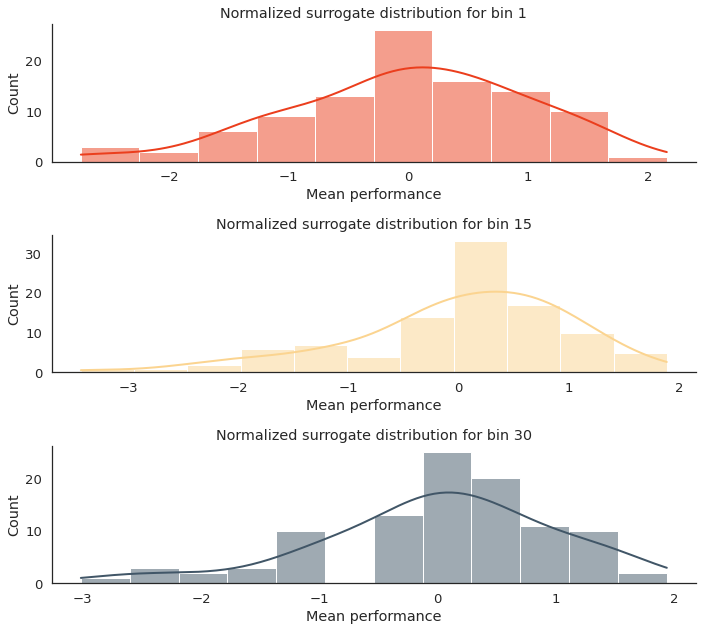

In [27]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 9))
axs[0].set_title(f'Normalized surrogate distribution for bin 1')
axs[0].set_xlabel('Mean performance')
axs[0].set_ylabel('Count')
sns.histplot(p_norm_bin1, kde=True, ax=axs[0])

axs[1].set_title(f'Normalized surrogate distribution for bin 15')
axs[1].set_xlabel('Mean performance')
axs[1].set_ylabel('Count')
sns.histplot(p_norm_bin15, kde=True, color=cs[1], ax=axs[1])

axs[2].set_title(f'Normalized surrogate distribution for bin 30')
axs[2].set_xlabel('Mean performance')
axs[2].set_ylabel('Count')
sns.histplot(p_norm_bin30, color=cs[3], kde=True, ax=axs[2])
plt.tight_layout()
sns.despine()

---

> **Exercise 4**: Redo the plot in Exercise 1 using the z-scored values computed. Also plot for each bin the maximum value of the (z-scored) surrogate distribution.

---

In [28]:
mean_acc_bins = np.zeros(spike_arr.shape[2])
max_val_pnorm = np.zeros(spike_arr.shape[2])
n_surr = 100

for ibin in range(spike_arr.shape[2]):

  # Compute surrogate distribution with bin
  surr_distrib = compute_surrogates(spike_arr, ibin=ibin, n_surr=n_surr, k=2)

  # Normalise (z-score)
  p_norm = (surr_distrib - np.mean(surr_distrib))/np.std(surr_distrib)
  
  # Take average z-score of normalized surrogate distribution
  mean_acc_bins[ibin] = np.mean(p_norm)

  # Take the maximum value of the z-scored surrogate distribution
  max_val_pnorm[ibin] = np.max(p_norm)

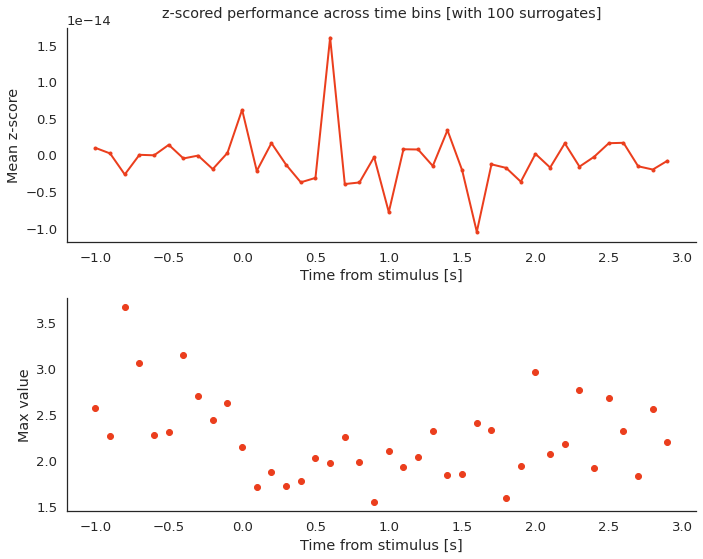

In [29]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

axs[0].set_title(f'z-scored performance across time bins [with {n_surr} surrogates]', y=1.02)
axs[0].set_ylabel('Mean z-score')
axs[0].set_xlabel('Time from stimulus [s]')
axs[0].plot(bins[:-1], mean_acc_bins, '.-')

axs[1].set_xlabel('Time from stimulus [s]')
axs[1].set_ylabel('Max value')
axs[1].plot(bins[:-1], max_val_pnorm, 'o')
plt.tight_layout()
sns.despine()

## 3 Analyze real data

---

> **Exercise 5**: Redo the plot in exercise 4 with the real data

---

In [30]:
import scipy.io as sio

In [31]:
# Load real data (note that the trials are longer)
data = sio.loadmat('/content/real_data_example.mat')

In [32]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'spktimes', 'srate', 'stim_times', 'stim_type'])

In [33]:
emp_spike_times = data['spktimes'][0]
emp_stim_times = data['stim_times']
emp_stim_types = data['stim_type'][0]

print(f'number of trials: {emp_stim_times.shape[0]} \n number of neurons: {emp_spike_times.shape[0]}')

number of trials: 94 
 number of neurons: 83


In [34]:
binwidth = 0.1 # seconds
ebins = np.arange(-1, 4.1, binwidth) # construct bins
n_emp_trials = emp_stim_types.shape[0] # number of experiments or trials
n_emp_cells = emp_spike_times.shape[0]

n_emp_trials, n_emp_cells

(94, 83)

### 3.1 Extract the number of spikes per unit time (bin)

In [35]:
emp_spike_arr = np.zeros((n_emp_cells, n_emp_trials, len(ebins)-1))

for c in range(n_emp_cells): # Iterate over cells
  
  spikes_c = emp_spike_times[c] # Select spike times of this cell

  for trial in range(1, n_emp_trials): # For each trial

    idx = np.where((spikes_c > emp_stim_times[trial]-1) & (spikes_c <= emp_stim_times[trial]+4))
    
    spikes_temp = spikes_c[idx] - emp_stim_times[trial]

    # Return the count of spikes at each bin and store
    count, _ = np.histogram(spikes_temp, ebins)
    emp_spike_arr[c, trial, :] = count

In [36]:
emp_spike_arr.shape # neurons x trials x bins

(83, 94, 50)

### 3.2 Plot activity of a sample neuron

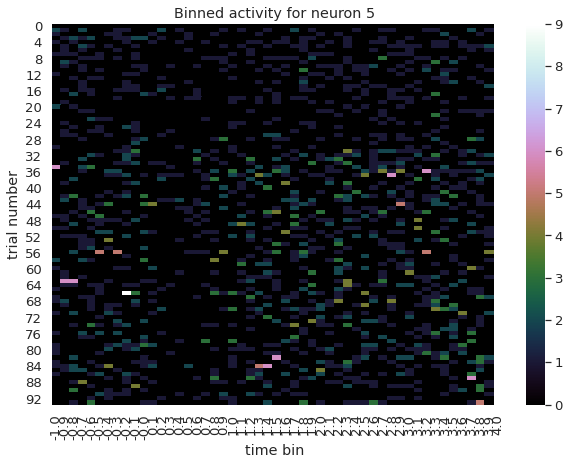

In [47]:
'''
Select a neuron
'''
neuron = 4

fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 7))
axs.set_title(f'Binned activity for neuron {neuron+1}')
hm = sns.heatmap(emp_spike_arr[neuron, :, :], xticklabels=np.round(ebins,1), cmap='cubehelix', ax=axs)
axs.set_xlabel('time bin')
axs.set_ylabel('trial number');

### 3.3 Create SVM classifier

In [38]:
k = 2 # Number of folds
y = emp_stim_types - 1 # to get [0, 1] stimuli

mean_acc_bins_emp = []

for bin in range(emp_spike_arr.shape[2]):
  
  # Select subset of data (time bin)
  X = emp_spike_arr[:, :, bin].T 
  kf = KFold(n_splits=k, shuffle=True) 
  kf.get_n_splits(X)
  model = svm.SVC() # Initialize model
  
  acc_score_fold = []

  for train_index, test_index in kf.split(X):
      X_train, X_test = X[train_index], X[test_index]
      y_train, y_test = y[train_index], y[test_index]

      model.fit(X_train, y_train)
      pred_values = model.predict(X_test)
      
      acc = accuracy_score(pred_values, y_test)
      acc_score_fold.append(acc)
      
  mean_acc_bins_emp.append(np.sum(acc_score_fold)/k)

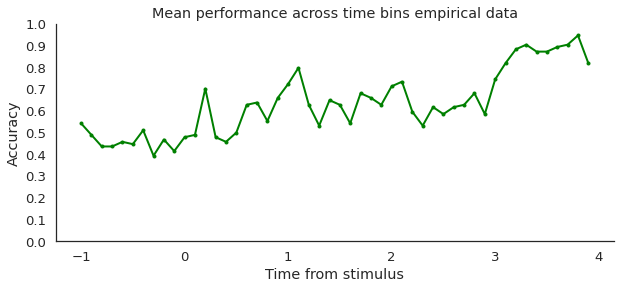

In [39]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
axs.set_title(f'Mean performance across time bins empirical data')
axs.set_ylabel('Accuracy')
axs.set_xlabel('Time from stimulus')
axs.plot(ebins[:-1], mean_acc_bins_emp, 'g.-')
axs.set_yticks(np.arange(0, 1.1, 0.1))
sns.despine()

### 3.4 Compute surrogate distributions

In [40]:
'''
Choose a bin and compute surrogates
'''

surrogate_distrib_ibin1_emp = compute_surrogates(emp_spike_arr, ibin=0, n_surr=100, k=2)

surrogate_distrib_ibin15_emp = compute_surrogates(emp_spike_arr, ibin=14, n_surr=100, k=2)

surrogate_distrib_ibin30_emp = compute_surrogates(emp_spike_arr, ibin=29, n_surr=100, k=2)

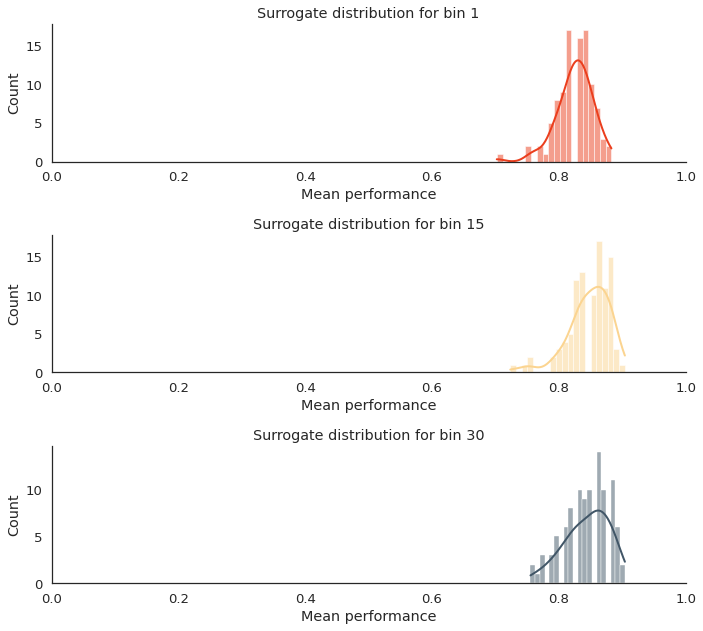

In [41]:
fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(10, 9))
axs[0].set_title(f'Surrogate distribution for bin 1')
axs[0].set_xlabel('Mean performance')
axs[0].set_ylabel('Count')
axs[0].set_xlim([0, 1])
sns.histplot(surrogate_distrib_ibin1_emp, kde=True, ax=axs[0], bins=20)

axs[1].set_title(f'Surrogate distribution for bin 15')
axs[1].set_xlabel('Mean performance')
axs[1].set_ylabel('Count')
axs[1].set_xlim([0, 1])
sns.histplot(surrogate_distrib_ibin15_emp, kde=True, color=cs[1], ax=axs[1], bins=20)

axs[2].set_title(f'Surrogate distribution for bin 30')
axs[2].set_xlabel('Mean performance')
axs[2].set_ylabel('Count')
axs[2].set_xlim([0, 1])
sns.histplot(surrogate_distrib_ibin30_emp, color=cs[3], kde=True, ax=axs[2], bins=20)
plt.tight_layout()
sns.despine()

Now we iterate through all the bins, compute the surrogate distribution and then normalize to get the z-scored values. Note that the variance in the distributions is much larger with the real data compared to our simulated neural activity.

In [42]:
mean_acc_bins_emp = np.zeros(emp_spike_arr.shape[2])
max_val_pnorm_emp = np.zeros(emp_spike_arr.shape[2])

for ibin in range(emp_spike_arr.shape[2]):

  # Compute surrogate distribution with bin
  surr_distrib = compute_surrogates(emp_spike_arr, ibin=ibin, n_surr=100, k=2)

  # Normalise (z-score)
  p_norm = (surr_distrib - np.mean(surr_distrib))/np.std(surr_distrib)
  
  # Average z-score
  mean_acc_bins_emp[ibin] = np.mean(p_norm)

  # Take the maximum value of the z-scored surrogate distribution
  max_val_pnorm_emp[ibin] = np.max(p_norm)

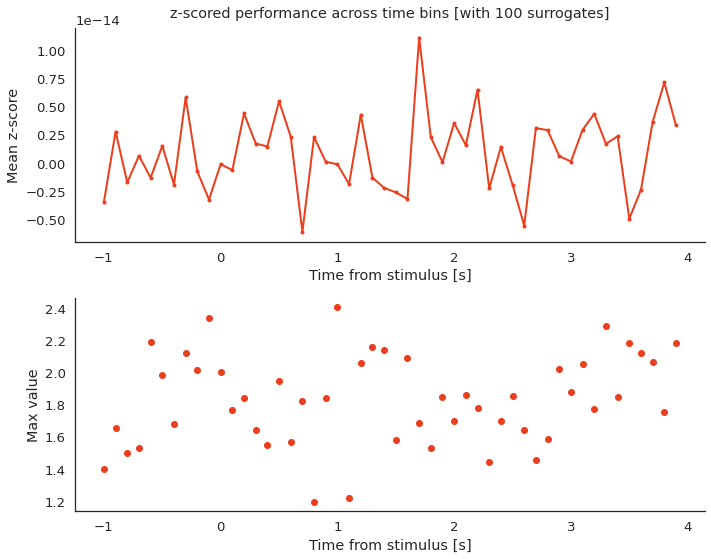

In [43]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

axs[0].set_title(f'z-scored performance across time bins [with {n_surr} surrogates]', y=1.02)
axs[0].set_ylabel('Mean z-score')
axs[0].set_xlabel('Time from stimulus [s]')
axs[0].plot(ebins[:-1], mean_acc_bins_emp, '.-')

axs[1].set_xlabel('Time from stimulus [s]')
axs[1].set_ylabel('Max value')
axs[1].plot(ebins[:-1], max_val_pnorm_emp, 'o')
plt.tight_layout()
sns.despine()